In [1]:
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import srsly
from datasets import load_from_disk
from matplotlib import ticker
from scipy.special import entr, softmax
from sklearn.manifold import TSNE
from tqdm.auto import tqdm

In [23]:
path_to_experiment = Path("../outputs/reinit_study")
path_to_experiment

PosixPath('../outputs/reinit_study')

In [85]:
epoch_results = []
for path in path_to_experiment.rglob("validation/epoch_level.jsonl"):
    df = pd.DataFrame(srsly.read_jsonl(path)).assign(
        strategy=path.parents[2].name,
        reinit=path.parents[3].name.split("_")[1],
    )
    epoch_results.append(df)

In [86]:
df = pd.concat(epoch_results)

In [87]:
df["budget"] = df["epoch"] * 25 + 100

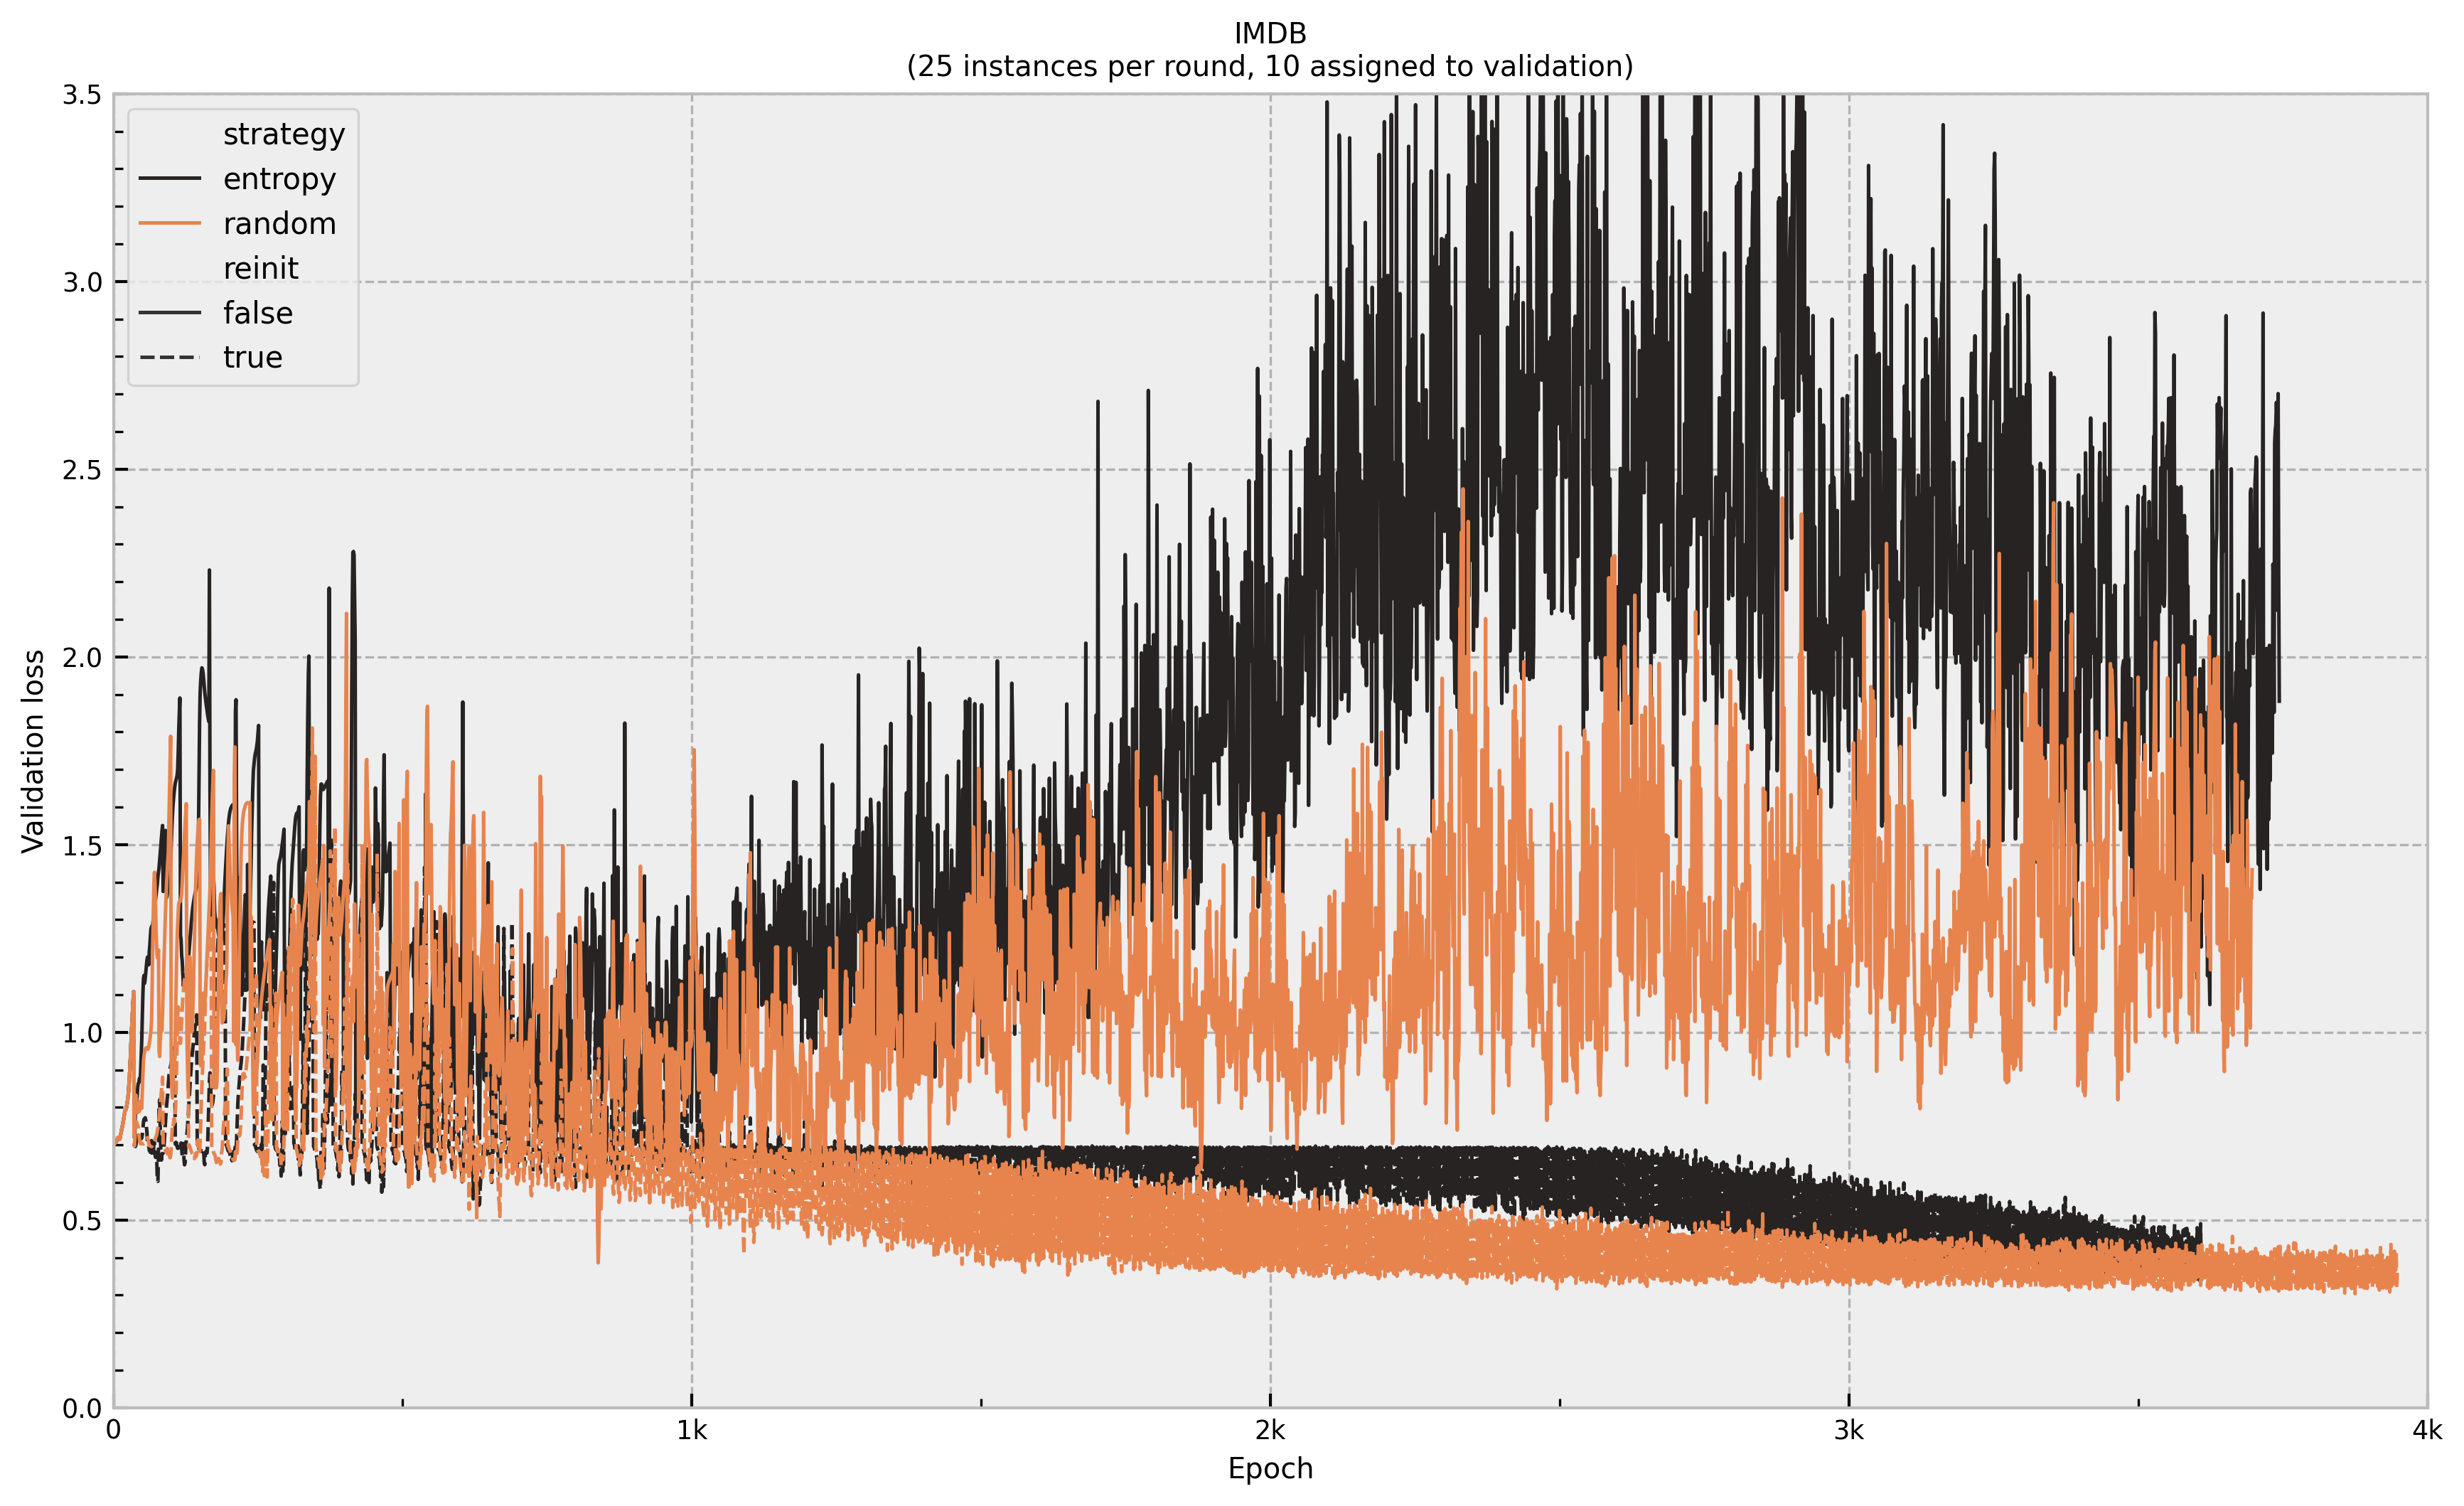

In [103]:
colors = sns.diverging_palette(250, 30, l=65, center="dark", n=3)

# sns.set_style("white", rc={"xtick.bottom" : True, "ytick.left" : True})
plt.style.use("bmh")
sns.set_context("paper")

# plot
fig, ax = plt.subplots(figsize=(14, 8))
fig.dpi = 300
sns.lineplot(
    df.groupby(["epoch", "strategy", "reinit"])["loss"]
    .mean()
    .to_frame("loss")
    .reset_index(),
    x="epoch",
    y="loss",
    hue="strategy",
    style="reinit",
    ax=ax,
    palette=colors[1:],
)

# add 90% line
# ax.hlines(0.88, *plt.xlim(), colors="red")
ax.set_xlabel("Epoch")
ax.set_ylabel("Validation loss")
ax.set_title("IMDB\n(25 instances per round, 10 assigned to validation)")

ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.1))
ax.xaxis.set_major_locator(ticker.MultipleLocator(1000))
ax.xaxis.set_minor_locator(ticker.MultipleLocator(500))
ax.xaxis.set_major_formatter(ticker.EngFormatter(sep=""))
ax.set_xlim(0, 4_000)
ax.set_ylim(0, 3.5)
ax.legend(fontsize=10)
plt.show()

In [68]:
colors

[(0.4265534711840377, 0.6260975213663689, 0.9072715683943962),
 (0.14918455888545099, 0.1381228160190642, 0.13476544093324597),
 (0.90499399934908, 0.5182704637470051, 0.3064196349089693)]

In [17]:
# data = []

# for dataset in path_to_experiment.iterdir():
#     for strategy in dataset.iterdir():
#         for reinit in strategy.iterdir():
#             for run in reinit.iterdir():
#                 data_seed, model_seed = run.name.split("_")
#                 results = pd.DataFrame(
#                     srsly.read_jsonl(run / "logs" / "test" / "epoch_level.jsonl")
#                 ).assign(
#                     data_seed=int(data_seed.split("=")[1]),
#                     model_seed=int(model_seed.split("=")[1]),
#                     dataset=dataset.name,
#                     strategy=strategy.name,
#                     reinit=eval(str(reinit.name).split("=")[-1]),
#                 )
#                 data.append(results)

In [ ]:
df.groupby(["strategy", "reinit", "dataset"])[["data_seed", "model_seed"]].size()

In [ ]:
df_agg = (
    df.groupby(["dataset", "strategy", "reinit", "round"])[
        ["accuracy", "f1_macro", "precision_macro", "recall_macro"]
    ]
    .agg(["mean", "std", "min", "max"])
    .stack(0)
    .reset_index()
    .rename(columns={"level_4": "metric"})
)

In [ ]:
plot_data = df_agg.loc[
    (df_agg["dataset"] == "imdb") & (df_agg["metric"] == "f1_macro")
].rename(columns={"reinit": "re-initialise"})
plot_data

In [18]:
sns.diverging_palette(250, 30, l=65, center="dark", n=3)

[(0.4265534711840377, 0.6260975213663689, 0.9072715683943962),
 (0.14918455888545099, 0.1381228160190642, 0.13476544093324597),
 (0.90499399934908, 0.5182704637470051, 0.3064196349089693)]

In [19]:
def plot(plot_data, dpi, ymin, hline, title, metric):
    # colors = sns.color_palette("Spectral", n_colors=len(plot_data["strategy"].unique()))
    colors = sns.diverging_palette(
        250, 30, l=65, center="dark", n=plot_data["strategy"].nunique()
    )

    # sns.set_style("white", rc={"xtick.bottom" : True, "ytick.left" : True})
    plt.style.use("bmh")
    sns.set_context("paper")

    # plot
    fig, ax = plt.subplots()
    fig.dpi = dpi

    sns.lineplot(
        data=plot_data,
        x="round",
        y="mean",
        hue="strategy",
        style="re-initialise",
        palette=colors,
        ax=ax,
    )

    # fill area between min and max for each group
    for group1, group1_data in plot_data.groupby("strategy"):
        group_color = colors[plot_data["strategy"].unique().tolist().index(group1)]

        for _, group2_data in group1_data.groupby("re-initialise"):
            group2_data

            ax.fill_between(
                group2_data["round"],
                group2_data["min"],
                group2_data["max"],
                alpha=0.2,
                color=group_color,
            )

    # add 90% line
    ax.hlines(hline, *plt.xlim(), colors="red")

    ax.yaxis.set_minor_locator(ticker.MultipleLocator(0.01))
    ax.xaxis.set_minor_locator(ticker.MultipleLocator(5))
    ax.set_xlim(0, 100)
    ax.set_ylim(ymin)

    fig.suptitle(title)
    ax.set_title("(25 instances per round, 10 assigned to validation)", fontsize=10)
    ax.set_ylabel(metric)
    ax.set_xlabel("Labelling round")
    ax.legend(fontsize=10, bbox_to_anchor=(1, 1))

    sns.despine()
    plt.show()

ValueError: Could not interpret value `round` for parameter `x`

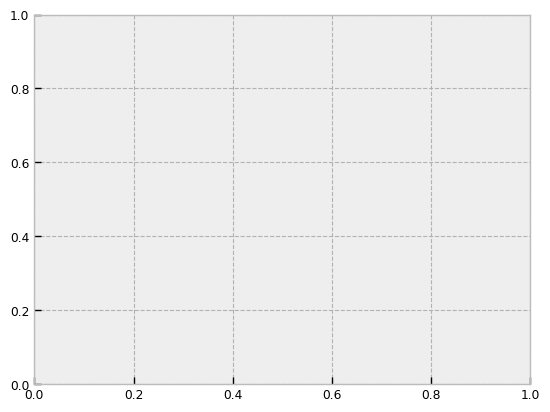

In [20]:
plot(df, 100, 0.0, None, "IMDB", metric="f1-score")

In [ ]:
for dataset in ("agnews", "imdb"):
    if dataset == "imdb":
        continue
    for metric in ("f1_macro", "accuracy"):
        plot_data = df_agg.loc[
            (df_agg["dataset"] == dataset) & (df_agg["metric"] == metric)
        ].rename(columns={"reinit": "re-initialise"})
        plot(
            plot_data,
            800,
            0.5 if dataset == "imdb" else 0.75,
            0.85 if dataset == "imdb" else 0.9,
            dataset.upper(),
            metric.title().replace("_", "-"),
        )